# Duel

Episode 20/200 | Gain A=141.00 | Gain B=91.00
Episode 40/200 | Gain A=121.00 | Gain B=116.00
Episode 60/200 | Gain A=132.00 | Gain B=37.00
Episode 80/200 | Gain A=166.00 | Gain B=21.00
Episode 100/200 | Gain A=120.00 | Gain B=55.00
Episode 120/200 | Gain A=149.00 | Gain B=59.00
Episode 140/200 | Gain A=139.00 | Gain B=39.00
Episode 160/200 | Gain A=151.00 | Gain B=31.00
Episode 180/200 | Gain A=137.00 | Gain B=32.00
Episode 200/200 | Gain A=153.00 | Gain B=33.00


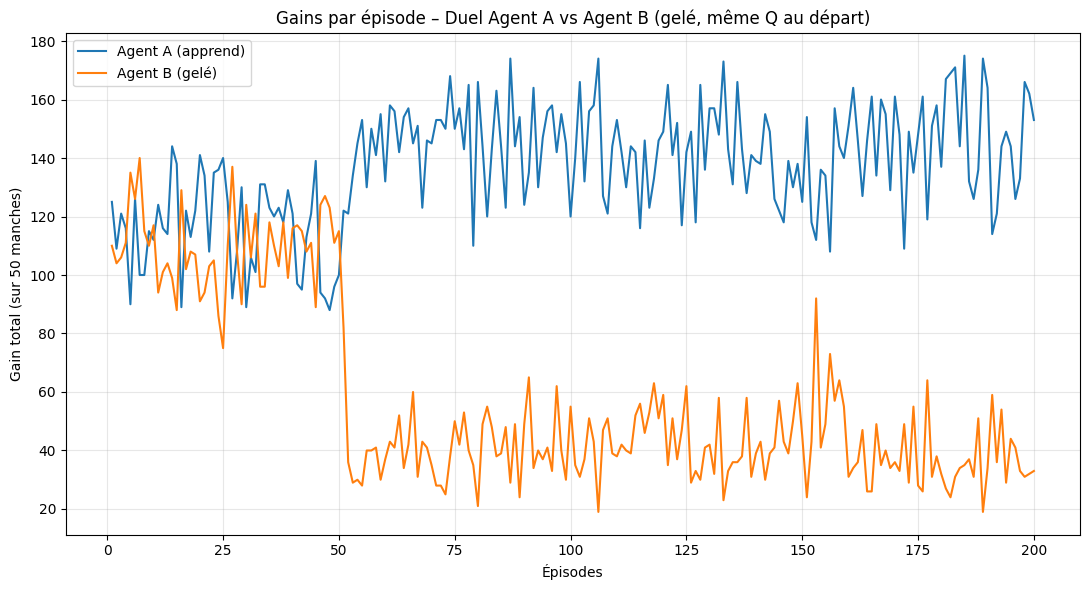

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) Payoffs - Prisoner's Dilemma
# ============================================================

R = 3
T = 5
P = 1
S = 0

PAYOFF_AGENT = {
    (0, 0): R,
    (0, 1): S,
    (1, 0): T,
    (1, 1): P
}

# ============================================================
# 2) Etats (même logique que ton code)
# ============================================================

START = 2  # "pas d'action précédente"

def last_pair_to_index(a_last, o_last):
    """
    0: START/START
    1: (C,C)
    2: (C,D)
    3: (D,C)
    4: (D,D)
    """
    if a_last == START and o_last == START:
        return 0
    if a_last == 0 and o_last == 0:
        return 1
    if a_last == 0 and o_last == 1:
        return 2
    if a_last == 1 and o_last == 0:
        return 3
    if a_last == 1 and o_last == 1:
        return 4
    raise ValueError(f"Couple (a_last={a_last}, o_last={o_last}) invalide.")

def make_state_index(opp_id, a_last, o_last):
    pair_idx = last_pair_to_index(a_last, o_last)  # 0..4
    return opp_id * 5 + pair_idx

# On réserve un 5e "opp_id" pour le duel
NUM_OPP = 5
NUM_STATES = NUM_OPP * 5  # 25
NUM_ACTIONS = 2


# ============================================================
# 3) Q-Learning Agent (identique, sauf taille Q = 25 états ici)
# ============================================================

class QLearningAgent:
    def __init__(self, alpha=0.10, gamma=0.95, epsilon=0.50, seed=123):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rng = np.random.default_rng(seed)
        self.Q = np.zeros((NUM_STATES, NUM_ACTIONS), dtype=float)

    def greedy_action(self, s_idx):
        q = self.Q[s_idx]
        best_actions = np.flatnonzero(q == q.max())
        return int(self.rng.choice(best_actions))

    def select_action(self, s_idx):
        a_star = self.greedy_action(s_idx)

        if self.rng.random() < self.epsilon:
            other_actions = [a for a in range(NUM_ACTIONS) if a != a_star]
            if other_actions:
                return int(self.rng.choice(other_actions))
            return a_star
        return a_star

    def update(self, s_idx, action, reward, s_next_idx):
        target = reward + self.gamma * np.max(self.Q[s_next_idx])
        self.Q[s_idx, action] += self.alpha * (target - self.Q[s_idx, action])


# ============================================================
# 4) Duel A vs B sur le même match (B gelé)
#    -> pas besoin de classe adversaire, on gère les 2 côté match
# ============================================================

def play_match_dual(agent_A, agent_B, opp_id, rounds=50, learn_A=True):
    """
    A joue contre B.
    - A choisit avec epsilon-greedy
    - B est gelé: joue greedy
    - A peut apprendre (learn_A=True)
    Retourne (gain_A, gain_B)
    """

    a_last = START
    b_last = START

    gain_A = 0.0
    gain_B = 0.0

    for t in range(rounds):
        # Pour éviter les erreurs, on n'utilise START/valeurs bizarres que dans START/START (t=0).
        # Ici, make_state_index accepte (START,START) uniquement.
        sA = make_state_index(opp_id, a_last, b_last)
        sB = make_state_index(opp_id, b_last, a_last)

        a = agent_A.select_action(sA)
        b = agent_B.greedy_action(sB)

        rA = PAYOFF_AGENT[(a, b)]
        rB = PAYOFF_AGENT[(b, a)]

        gain_A += rA
        gain_B += rB

        sA_next = make_state_index(opp_id, a, b)

        if learn_A:
            agent_A.update(sA, a, rA, sA_next)

        a_last, b_last = a, b

    return gain_A, gain_B


# ============================================================
# 5) Main: load Q-table + duel + plot
# ============================================================

if __name__ == "__main__":

    # ---- Charger la Q-table apprise dans ton premier script ----
    data = np.load("trained_agent_qtable.npz")

    Q_loaded = data["Q"]
    alpha = float(data["alpha"])
    gamma = float(data["gamma"])
    epsilon = float(data["epsilon"])

    # Ton training initial a NUM_OPP=4 -> Q shape (20,2)
    # Ici on veut (25,2) pour SELF_OPP_ID=4
    if Q_loaded.shape == (20, 2):
        Q_ext = np.zeros((25, 2), dtype=float)
        Q_ext[:20, :] = Q_loaded
        Q_loaded = Q_ext

    if Q_loaded.shape != (25, 2):
        raise ValueError(f"Q-table inattendue: {Q_loaded.shape}. Attendu (20,2) ou (25,2).")

    # ---- Créer deux agents identiques au départ ----
    agent_A = QLearningAgent(alpha=alpha, gamma=gamma, epsilon=epsilon, seed=123)
    agent_B = QLearningAgent(alpha=alpha, gamma=gamma, epsilon=0.0, seed=999)  # gelé

    agent_A.Q = Q_loaded.copy()
    agent_B.Q = Q_loaded.copy()

    # ---- Duel ----
    SELF_OPP_ID = 4
    episodes = 200
    rounds = 50

    gains_A = []
    gains_B = []
    avg_gain = []

    for ep in range(episodes):
        gA, gB = play_match_dual(
            agent_A,
            agent_B,
            opp_id=SELF_OPP_ID,
            rounds=rounds,
            learn_A=True
        )

        gains_A.append(gA)
        gains_B.append(gB)
        avg_gain.append((gA + gB) / 2.0)

        if (ep + 1) % 20 == 0:
            print(f"Episode {ep+1}/{episodes} | Gain A={gA:.2f} | Gain B={gB:.2f}")

    # ---- Plot (comme ton 1er script, mais 2 adversaires) ----
    x = np.arange(1, episodes + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(x, gains_A, label="Agent A (apprend)")
    plt.plot(x, gains_B, label="Agent B (gelé)")
    

    plt.xlabel("Épisodes")
    plt.ylabel(f"Gain total (sur {rounds} manches)")
    plt.title("Gains par épisode – Duel Agent A vs Agent B (gelé, même Q au départ)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()